In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize
import math
import sktime
from sktime.registry import all_estimators
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_squared_percentage_error, mean_squared_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import make_reduction
import warnings
warnings.filterwarnings("ignore")

In [2]:
df_naive = pd.read_csv('updated_dataset.csv')
df_naive.sample(1)

,Date/Time,Air Quality Index,Carbon Monoxide,Hydrogen Sulphide,Methane,Nitric Oxide,Nitrogen Dioxide,Non-methane Hydrocarbons,Outdoor Air Temperature,Ozone,PM10 Mass,PM2.5 Mass,Relative Humidity,Std. Dev. of Wind Direction,Sulphur Dioxide,Total Hydrocarbons,Total Oxides Of Nitrogen,Wind Direction,Wind Speed
220,2015-08-09,2.5564,0.104167,0.0013,2.1375,0.002,0.005133,0.5375,23.4861,0.028567,13.6667,9.005033,54.5,32.8333,0.00025,2.4729,0.007167,135.95835,6.70835


In [3]:
# Load the data
df_naive['Date/Time'] = pd.to_datetime(df_naive['Date/Time'])
df_naive = df_naive.drop('PM10 Mass', axis=1)

In [4]:
df_naive.dropna(inplace=True)
df_naive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1077 entries, 0 to 1095
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date/Time                    1077 non-null   datetime64[ns]
 1   Air Quality Index            1077 non-null   float64       
 2   Carbon Monoxide              1077 non-null   float64       
 3   Hydrogen Sulphide            1077 non-null   float64       
 4   Methane                      1077 non-null   float64       
 5   Nitric Oxide                 1077 non-null   float64       
 6   Nitrogen Dioxide             1077 non-null   float64       
 7   Non-methane Hydrocarbons     1077 non-null   float64       
 8   Outdoor Air Temperature      1077 non-null   float64       
 9   Ozone                        1077 non-null   float64       
 10  PM2.5 Mass                   1077 non-null   float64       
 11  Relative Humidity            1077 non-null 

In [6]:
from sktime.forecasting.base import BaseForecaster
from prophet import Prophet
from sktime.forecasting.theta import ThetaForecaster

In [7]:
# Custom ProphetAdapter
class ProphetAdapter(BaseForecaster):
    def __init__(self, *args, **kwargs):
        self.model = Prophet(*args, **kwargs)

    def fit(self, y_train, X_train=None, fh=None):
        y_train = y_train.to_frame().reset_index()
        y_train.columns = ["ds", "y"]
        self.model.fit(y_train)
        return self

    def _predict(self, fh, X=None, return_pred_int=False, alpha=0.05):
        future = self.model.make_future_dataframe(periods=max(fh), include_history=False)
        y_pred = self.model.predict(future)
        return pd.Series(y_pred["yhat"].values, index=future["ds"])

In [8]:
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

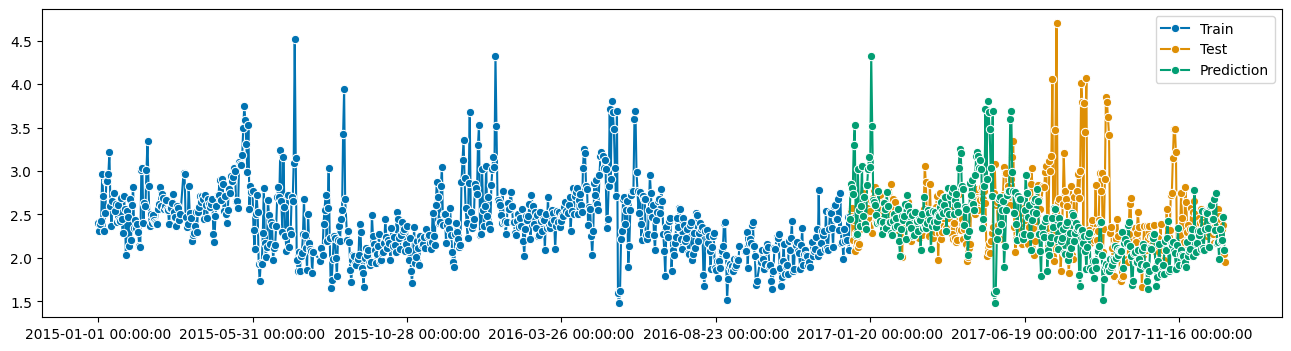

In [9]:
# Convert the DataFrame into an sktime Series
y = pd.Series(df_naive['Air Quality Index'].values, index=df_naive['Date/Time'])
y = y.asfreq('D')  # Set the frequency to daily

# Split the data into training and testing sets
y_train, y_test = temporal_train_test_split(y, test_size=365)

# Create a NaiveForecaster model with the last strategy
forecaster = NaiveForecaster(strategy="last", sp = 365)

# Fit the model to the training data
forecaster.fit(y_train)

# Generate predictions for the test data
y_pred = forecaster.predict(fh=[i for i in range(len(y_test))])

# Plot the training data, test data, and predictions
plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Prediction"])

In [10]:
# Fit the model to the entire dataset
forecaster.fit(y)

# Generate predictions for the next 30 days
next_month = pd.date_range(y.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
fh_next_month = [i+1 for i in range(len(next_month))]
y_pred_next_month = forecaster.predict(fh=fh_next_month)

# Create a DataFrame with the predicted Air Quality Index values and the corresponding dates
predictions = pd.DataFrame({'Date/Time': next_month, 'Predicted Air Quality Index': y_pred_next_month})
predictions.reset_index(drop=True, inplace=True)
print(predictions)

    Date/Time  Predicted Air Quality Index
0  2018-01-01                     2.547133
1  2018-01-02                     2.579700
2  2018-01-03                     2.202767
3  2018-01-04                     2.441133
4  2018-01-05                     2.074767
5  2018-01-06                     2.290700
6  2018-01-07                     2.185033
7  2018-01-08                     2.129067
8  2018-01-09                     2.156067
9  2018-01-10                     2.332267
10 2018-01-11                     2.495767
11 2018-01-12                     2.502867
12 2018-01-13                     2.745667
13 2018-01-14                     2.499133
14 2018-01-15                     2.492133
15 2018-01-16                     2.580533
16 2018-01-17                     2.571300
17 2018-01-18                     2.458533
18 2018-01-19                     2.525300
19 2018-01-20                     2.536033
20 2018-01-21                     2.668767
21 2018-01-22                     2.283833
22 2018-01-

(<Figure size 1600x400 with 1 Axes>, <Axes: >)

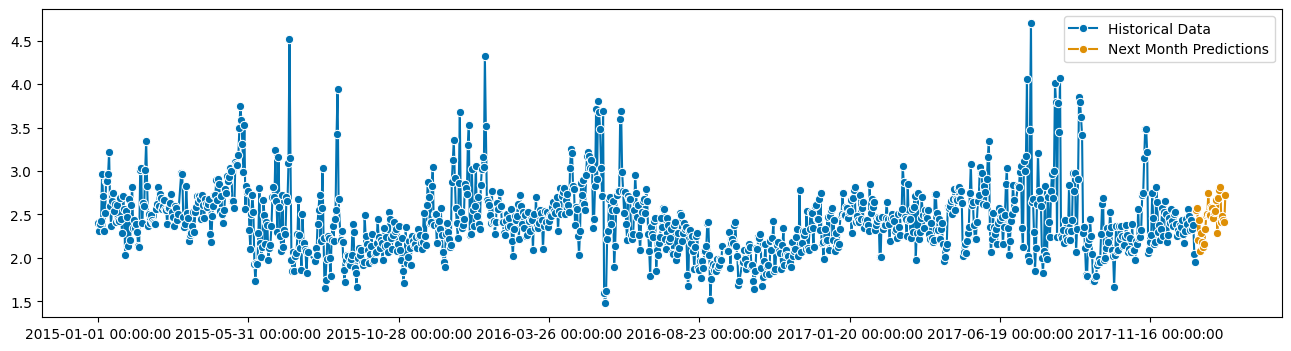

In [11]:
plot_series(y, y_pred_next_month, labels=["Historical Data", "Next Month Predictions"])

In [108]:
predictions.mean()

Predicted Air Quality Index    2.468566
dtype: float64

In [109]:
predictions.median()

Predicted Air Quality Index    2.49395
dtype: float64

In [110]:
df_2018 = pd.read_csv('Final_Data.csv')
df_2018.sample(1)

,Date/Time,Air Quality Index,Ammonia,Benzene,Carbon Monoxide,Catch of Standard Collector,Delta Temperature,Ethylbenzene,Ethylene,Hydrogen Sulphide,...,Std. Dev. of Wind Speed,Styrene,Sulphur Dioxide,Toluene,Total Hydrocarbons,Total Oxides Of Nitrogen,Wind Direction,Wind Speed,"m,p-Xylene",o-Xylene
1082,2017-12-18,2.395136,0.0012,0.0,0.19204,0.0,0.29165,0.0,0.69565,0.000112,...,2.855957,0.0,0.000685,0.0,2.071267,0.007548,282.270829,11.707296,0.0,0.0


In [111]:
df_aqi = df_2018[['Date/Time', 'Air Quality Index']]
df_aqi['Date/Time'] = pd.to_datetime(df_aqi['Date/Time'])
df_aqi.set_index('Date/Time', inplace=True)

start_date = pd.Timestamp('2018-01-01')
end_date = pd.Timestamp('2018-01-30')
df_aqi = df_aqi.loc[start_date:end_date]

print(df_aqi)

            Air Quality Index
Date/Time                    
2018-01-01           2.251564
2018-01-02           2.322907
2018-01-03           2.267614
2018-01-04           2.476693
2018-01-05           3.148729
2018-01-06           2.663729
2018-01-07           2.347014
2018-01-08           2.372957
2018-01-09           2.291114
2018-01-10           2.310764
2018-01-11           2.260207
2018-01-12           2.366471
2018-01-13           2.504743
2018-01-14           2.364000
2018-01-15           2.324900
2018-01-16           2.655636
2018-01-17           2.393986
2018-01-18           2.386336
2018-01-19           2.310064
2018-01-20           2.523414
2018-01-21           2.292129
2018-01-22           2.706029
2018-01-23           2.169664
2018-01-24           2.404300
2018-01-25           2.220329
2018-01-26           1.961329
2018-01-27           1.980093
2018-01-28           1.929300
2018-01-29           2.040271
2018-01-30           1.988979


In [130]:
def forecast_columns(column_name, df, test_size=365, sp=365, n_predictions=30):
    y = pd.Series(df[column_name].values, index=df['Date/Time'])
    y = y.asfreq('D')

    y_train, y_test = temporal_train_test_split(y, test_size=test_size)

    forecaster = NaiveForecaster(strategy="last", sp=sp)
    forecaster.fit(y_train)

    y_pred = forecaster.predict(fh=[i for i in range(len(y_test))])
    # plot_series(y_train, y_test, y_pred, labels=["Train", "Test", "Prediction"])

    forecaster.fit(y)
    next_month = pd.date_range(y.index[-1] + pd.Timedelta(days=1), periods=n_predictions, freq='D')
    fh_next_month = [i+1 for i in range(len(next_month))]
    y_pred_next_month = forecaster.predict(fh=fh_next_month)

    predictions = pd.DataFrame({'Date/Time': next_month, f'Predicted {column_name}': y_pred_next_month})
    predictions.reset_index(drop=True, inplace=True)

    return predictions

In [131]:
columns_to_forecast = ['Air Quality Index', 'Carbon Monoxide', 'Hydrogen Sulphide', 
                       'Methane', 'Nitric Oxide', 'Nitrogen Dioxide',
                       'Outdoor Air Temperature', 'Ozone', 'PM2.5 Mass', 'Relative Humidity']

Forecasting Air Quality Index:
Forecasting Carbon Monoxide:
Forecasting Hydrogen Sulphide:
Forecasting Methane:
Forecasting Nitric Oxide:
Forecasting Nitrogen Dioxide:
Forecasting Outdoor Air Temperature:
Forecasting Ozone:
Forecasting PM2.5 Mass:
Forecasting Relative Humidity:


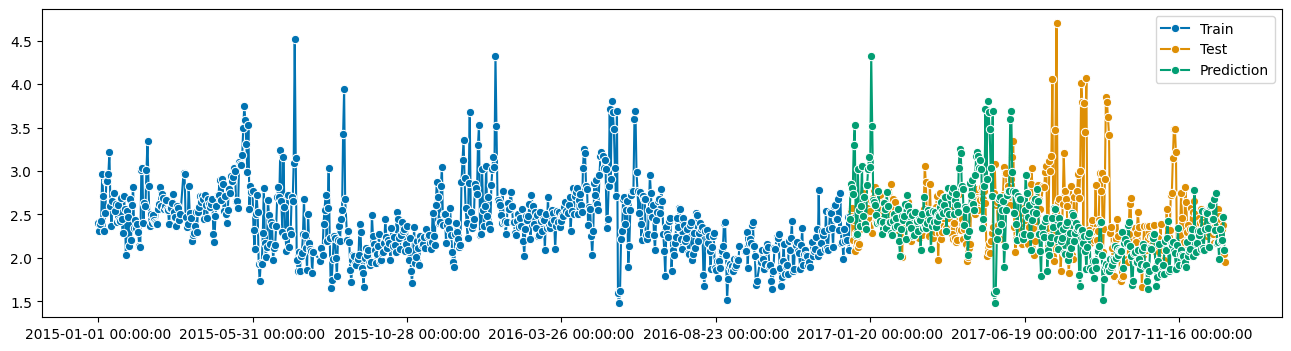

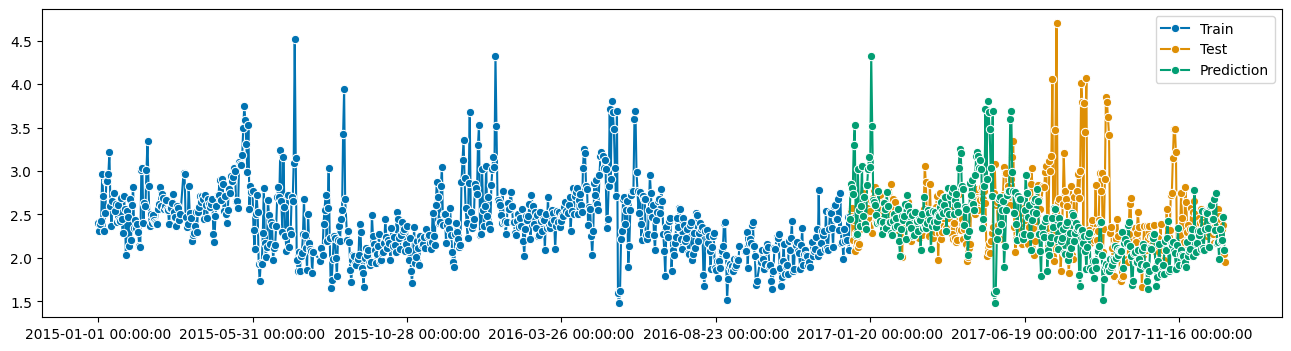

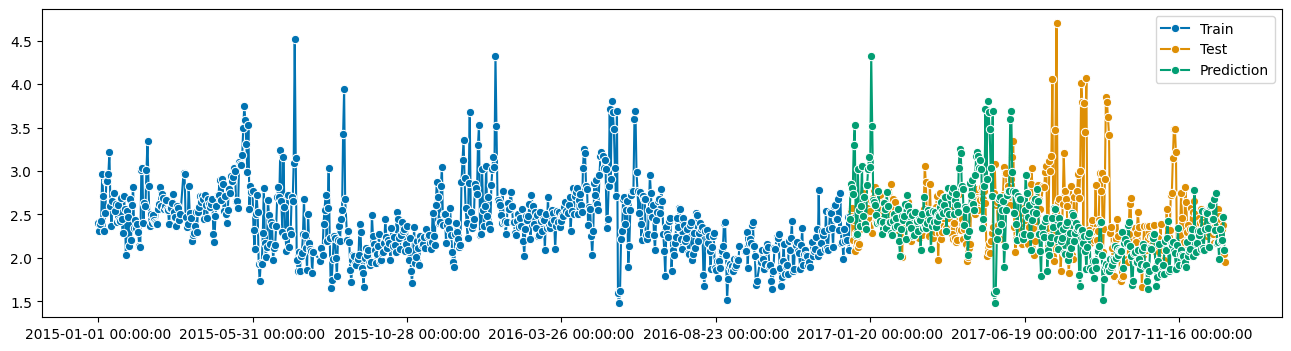

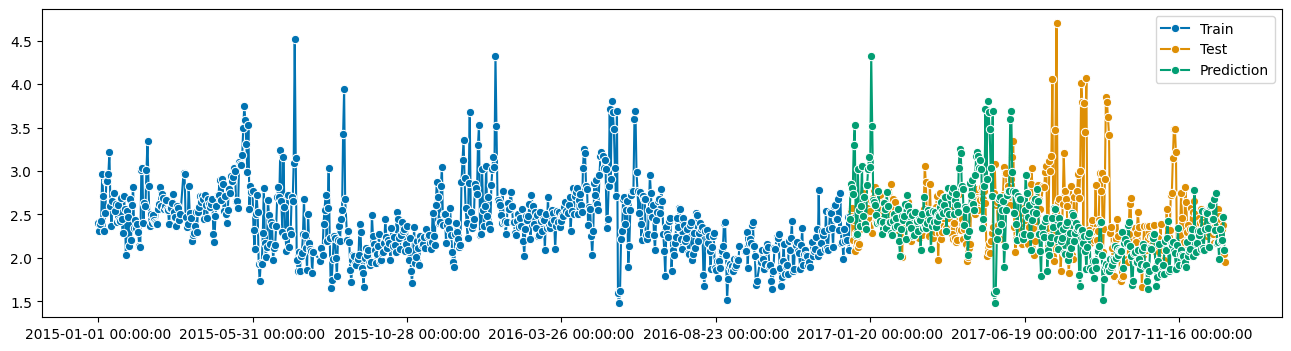

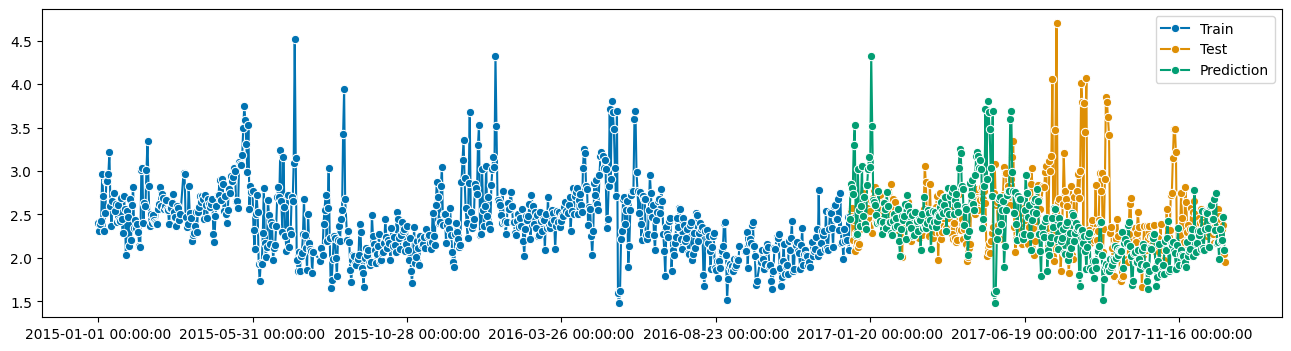

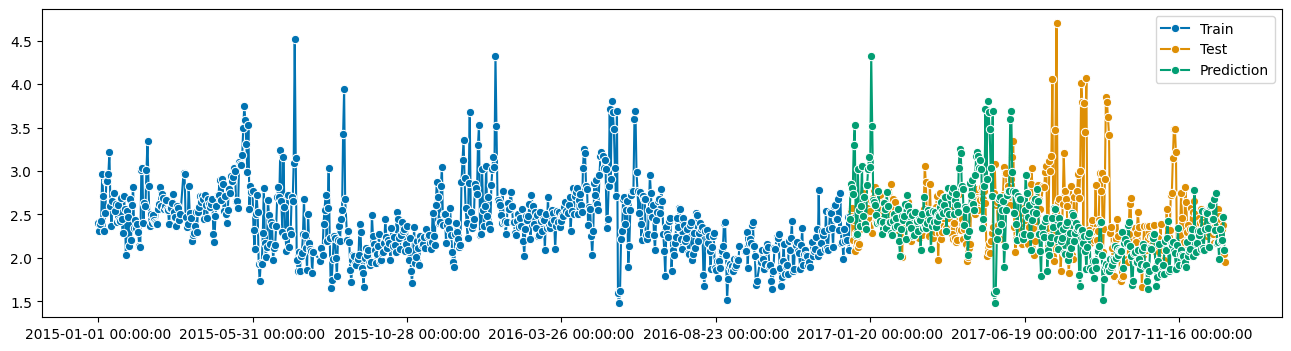

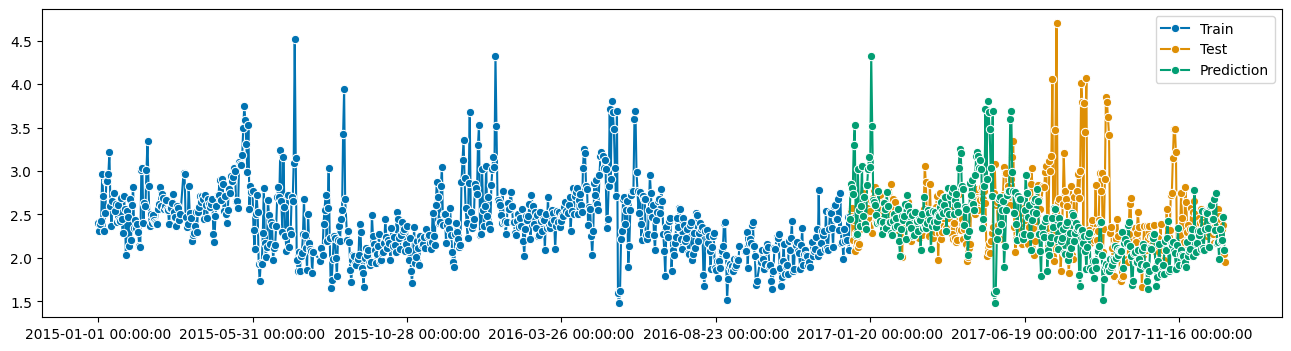

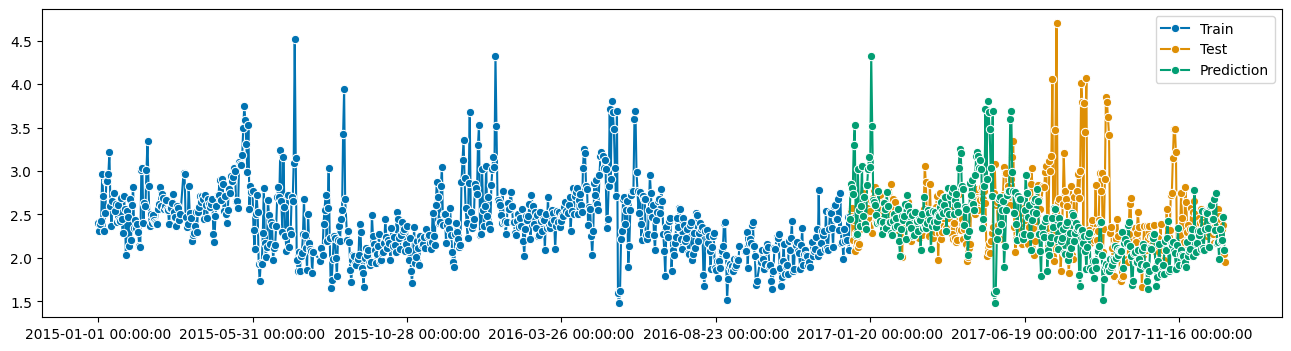

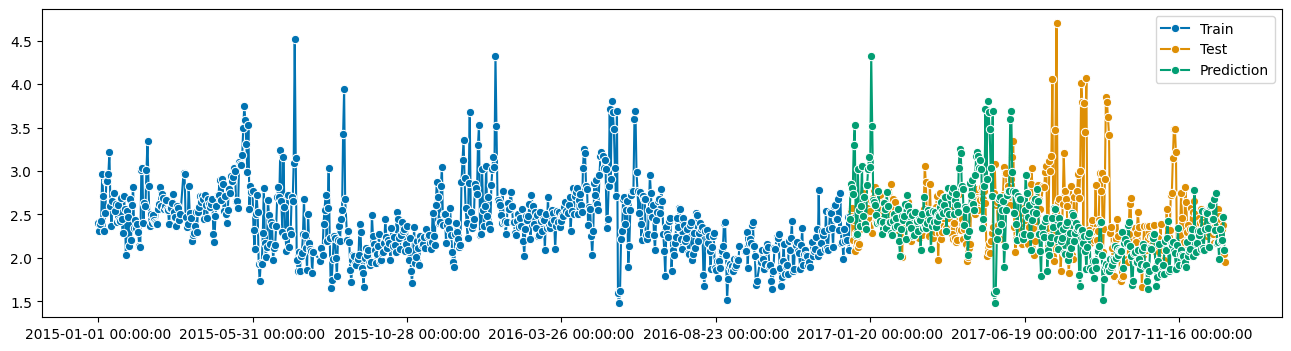

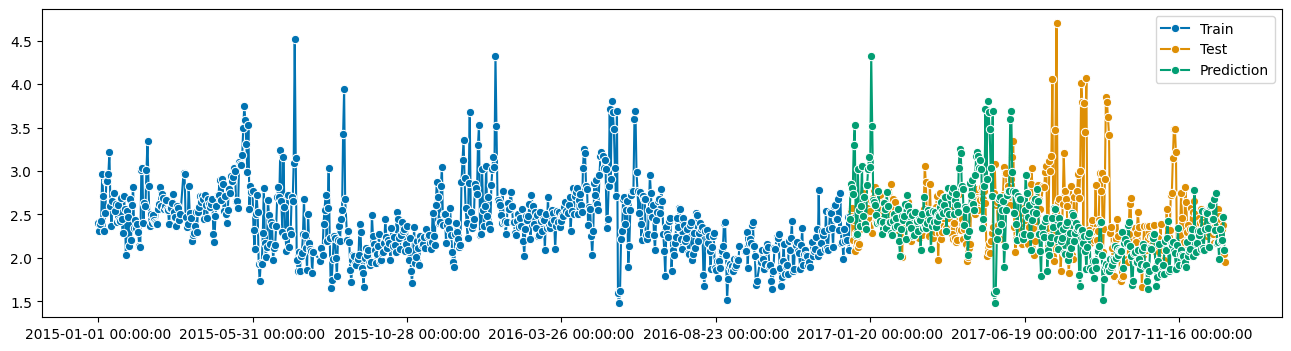

In [132]:
# Loop through the columns and call the forecast_column function
for column in columns_to_forecast:
    print(f"Forecasting {column}:")
    pred_df = forecast_columns(column, df_naive)